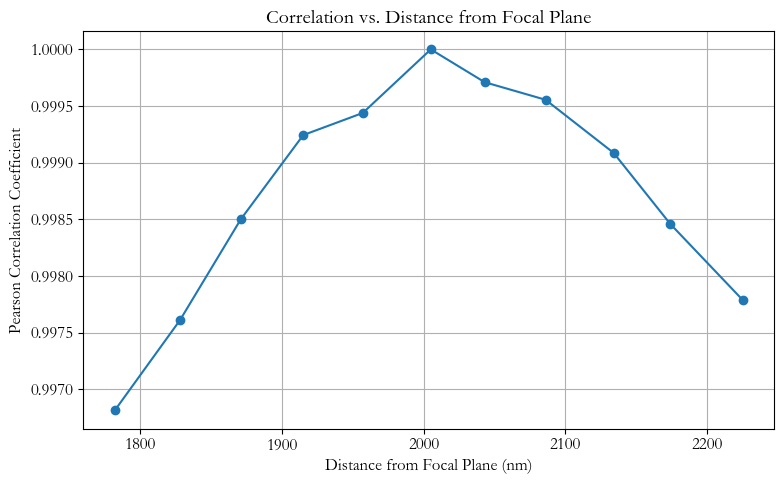

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Mar 28 22:22:25 2025

@author: yanjie
"""

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fft import fft2, fftshift
from scipy.stats import pearsonr

# Directory and filenames
base_path = r"D:\bead image\Beadimages\Beadimage1"
files = [
    f for f in os.listdir(base_path)
    if f.startswith("Moving") and f.endswith(".png")
]

# Function to extract distance, handles potential errors, and returns filename and distance
def extract_distance_and_filename(fname):
    match = re.search(r'-(\d+)nm', fname)
    if match:
        distance = int(match.group(1))
        return fname, distance
    else:
        return fname, None  # Return None for distance if not found

# Sort files based on extracted distance
files_with_distances = [extract_distance_and_filename(f) for f in files]
files_with_distances = [
    (fname, distance) for fname, distance in files_with_distances if distance is not None
]  # Filter out files where distance wasn't found.
files_with_distances.sort(key=lambda x: x[1])  # Sort by distance
sorted_files = [fname for fname, _ in files_with_distances]  # extract sorted filenames

# Specify reference filename
ref_filename = "MovingBead-0_-2005nm.png"


# Get the index of the reference image
try:
    ref_index = sorted_files.index(ref_filename)
except ValueError:
    raise ValueError(f"{ref_filename} not found in file list.")

# Define window size
window_size = 5

# Safely get the subset of files
start_index = max(ref_index - window_size, 0)
end_index = min(ref_index + window_size + 1, len(sorted_files))
selected_files = sorted_files[start_index:end_index]


#%%
# Reference image
ref_img = Image.open(os.path.join(base_path, ref_filename)).convert("L")

# Determine minimum common shape across all images
shapes = [Image.open(os.path.join(base_path, f)).convert("L").size[::-1] for f in sorted_files]
min_shape = (min(s[0] for s in shapes), min(s[1] for s in shapes))

# Crop and FFT the reference image
ref_img_cropped = np.array(ref_img)[:min_shape[0], :min_shape[1]]
ref_fft = fftshift(fft2(ref_img_cropped))

# High-pass filter function
def high_pass_filter(img_fft, threshold_ratio=0.005):
    h, w = img_fft.shape
    cx, cy = w // 2, h // 2
    radius = int(min(cx, cy) * threshold_ratio)
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2)
    mask = dist_from_center >= radius
    return img_fft * mask

ref_fft_filtered = high_pass_filter(ref_fft)

# Extract distance from filename
def extract_distance(fname):
    match = re.search(r'-(\d+)nm', fname)
    return int(match.group(1)) if match else None



# Compute correlation coefficients
results = []
#for fname in files:
for fname in selected_files:
    img = Image.open(os.path.join(base_path, fname)).convert("L")
    img_cropped = np.array(img)[:min_shape[0], :min_shape[1]]
    img_fft = fftshift(fft2(img_cropped))
    img_fft_filtered = high_pass_filter(img_fft)

    # Flatten and compute Pearson correlation
    r_value, _ = pearsonr(ref_fft_filtered.flatten().real, img_fft_filtered.flatten().real)
    distance = extract_distance(fname)
    if distance is not None:
        results.append((distance, r_value))

# Sort and save results
results.sort(key=lambda x: x[0])
df_results = pd.DataFrame(results, columns=["Distance (nm)", "Pearson r"])

# Plot
plt.figure(figsize=(8, 5))
plt.plot(df_results["Distance (nm)"], df_results["Pearson r"], marker='o')
plt.title("Correlation vs. Distance from Focal Plane")
plt.xlabel("Distance from Focal Plane (nm)")
plt.ylabel("Pearson Correlation Coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()
